In [20]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/grisard_malo/PycharmProjects/githubFacet/facet'
added `/Users/grisard_malo/PycharmProjects/githubFacet/pytools/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/facet/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/sklearndf/src` to python paths


# Imports

Conventional imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Gamma Facet imports

In [3]:
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

Sklearndf imports

Instead of using the "regular" scikit-learn package, we are using the `sklearndf` (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata such as column names when passing the data through the scikit-learn learners.  

In [4]:
# sklearndf
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF


The sklearn.linear_model.stochastic_gradient module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.


In [5]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

In [6]:
# this
from sklearn.pipeline import Pipeline
# becomes this
from sklearndf.pipeline import PipelineDF

In [7]:
from facet import Sample
import pandas as pd
from sklearndf.pipeline import PipelineDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.transformation import SimpleImputerDF

## Problem introduction
For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is a likelihood of drill breakdown based on empirical data under the given parametric set. This dataset will be used to estimate failure likelihoods while drilling.

In [8]:
data_root = Path("sphinx/source/tutorial/")
df = pd.read_csv(data_root.joinpath("water_drill_dataset.csv"), sep=";", encoding="utf-8")

In [9]:
df.head()

,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (m/s),Linear4,Mud Flow in (m3/s),Nonlinear2,Nonlinear3,Temperature (C),Hole diameter (m),Failure likelihood (%),Inverse Rate of Penetration (s/m)
0,306.141821,9849.952938,927.968837,2.902467,0.001000,-0.385633,50.299606,0.793721,0.153503,34.516570,6.373932,25.092477,-0.339774
1,324.039405,10744.516916,1106.187754,2.106770,0.007870,0.199908,72.140061,0.155269,0.767234,41.861162,7.507640,56.071090,0.583143
2,345.377055,5393.241061,898.168085,3.909455,0.004817,0.647058,10.908230,0.598722,0.101157,58.560955,6.180673,29.844640,-2.817546
3,356.709497,6776.865696,769.165223,2.473607,0.005551,-0.419456,51.029350,0.588158,0.464393,72.925042,5.368265,41.938061,7.019297
4,328.437275,6024.116387,215.202605,3.033681,0.003676,0.006490,44.159394,0.278210,0.190692,43.992966,2.092908,24.455330,-0.886233


In [10]:
# Sample
sample = Sample(observations=df, target="Failure likelihood (%)")

In [11]:
# Wrapper class to implement Boruta feature selection
boruta = BorutaDF(
    estimator = RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=3), 
    n_estimators="auto",
    random_state=42, 
    verbose=0, 
    max_iter=200
)

preprocessing_pipeline = PipelineDF(
    steps = [
        ("impute", SimpleImputerDF()),
        ("feature selection", boruta)
    ]
)

preprocessing_pipeline.fit(X=sample.features, y=sample.target)

print(f"Selected features: {list(preprocessing_pipeline.features_out)}")
sample_selected = sample.keep(preprocessing_pipeline.features_out)

Selected features: ['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)', 'Mud density (kg/L)', 'Rate of Penetration (m/s)', 'Hole diameter (m)', 'Inverse Rate of Penetration (s/m)']


We can see that the key features that we would expect to effect the safety of the operation are still being included after the feature selection. A working hypothesis of how these influence the target are: 
- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear
- **Rotation speed**: Too fast rotation speed can lead to overheating and breaking the material, too low rotation renders drilling more difficult and is not economical
- **Depth of operation**: As a simplification we will take for granted that the deeper we dig, the denser the soil will be, increasing the likelihood of either a collapse or breaking equipment wear 
- **Hole diameter**: Thinner wholes are used in deeper sections of the well hence usually relate to more dangerous zones
- **Rate Of Penetration**: A higher ROP leads to more wear & tear of the equipment and thus we expect a positive effect
- **Inverse Rate of Penetration**: As described by its name, this feature is the inverse of the ROP
- **Mud density**: Mud density needs to soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)

# Cross validation

We will use a simple Bootstrap for the time series analysis here. Note that if we were given a time series dataset here (i.e. if we had timestamps of the GT readings) we could use a stationary bootstrap here using `StationaryBootstrapCV`)

# Regressor Pipeline

In [12]:
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

In [13]:
cv = BootstrapCV(n_splits=10, random_state=42)

rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=500, random_state=42),
)

lgbm_pipeline = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)


grid = [
    LearnerGrid(
        pipeline=rf_pipeline, 
        learner_parameters={ 
            "min_samples_leaf": [8, 11, 15]
        } 
        ),
    LearnerGrid(
        pipeline=lgbm_pipeline, 
        learner_parameters={ 
            "min_data_in_leaf": [8, 11, 15]
        }
    )
]

In [14]:
ranker = LearnerRanker( 
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_selected)

In [15]:
ranker.best_model

RegressorPipelineDF(regressor=LGBMRegressorDF(min_data_in_leaf=15,
                                              random_state=42))

In [16]:
print(ranker.summary_report())

Rank  1:         LGBMRegressorDF, ranking_score=    0.469, scores_mean=    0.628, scores_std=   0.0798, parameters={regressor__min_data_in_leaf=15}

Rank  2:         LGBMRegressorDF, ranking_score=    0.438, scores_mean=    0.604, scores_std=    0.083, parameters={regressor__min_data_in_leaf=11}

Rank  3:         LGBMRegressorDF, ranking_score=    0.411, scores_mean=    0.595, scores_std=    0.092, parameters={regressor__min_data_in_leaf=8}

Rank  4: RandomForestRegressorDF, ranking_score=    0.269, scores_mean=     0.38, scores_std=   0.0551, parameters={regressor__min_samples_leaf=8}

Rank  5: RandomForestRegressorDF, ranking_score=    0.263, scores_mean=    0.353, scores_std=   0.0448, parameters={regressor__min_samples_leaf=11}

Rank  6: RandomForestRegressorDF, ranking_score=    0.227, scores_mean=    0.329, scores_std=   0.0508, parameters={regressor__min_samples_leaf=15}



# Model inspection

In [17]:
from facet.inspection import LearnerInspector

inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [18]:
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

#### Feature redundancy

When plotting out the feature redundancy, we can see that there are some features which contain the same information to the model. In this case, these features are the vertical depth of the operation and the bit depth. 
Intuitively, we can see why these two features are redundant, as the depth of operation and the hole diameter are highly connected as drillers use thinner drilling bits as they drill deeper into the earth.

As we don't want either of the features to confuse the model inference during the simulation step, we should **remove the hole diameter** for this example.

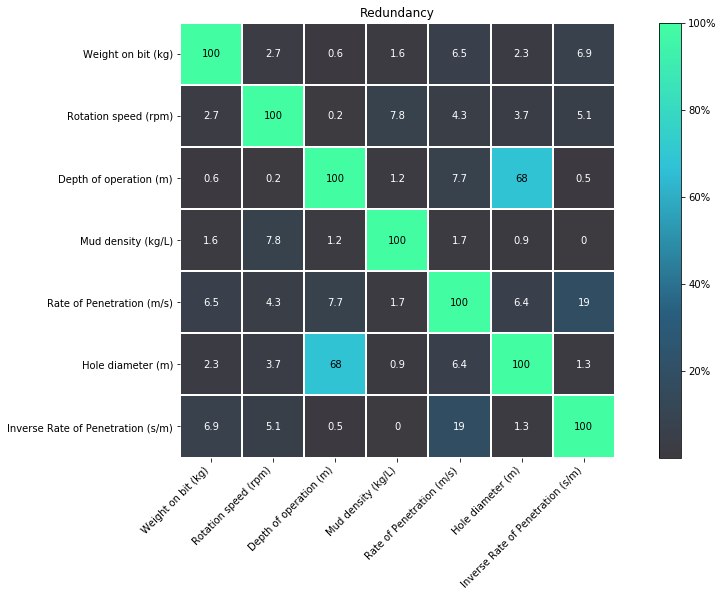

In [21]:
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

#### Feature synergy
When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the **weight on the bit and the rotation speed in combination appear to have a high synergy.** Those two features are also synergestic with the RoP, which makes sense as the RoP is a consequence of the weight on bit and rotation speed that is applied.

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionally large impact on the wear of the equipment, thus drastically to higher failure likelihood.

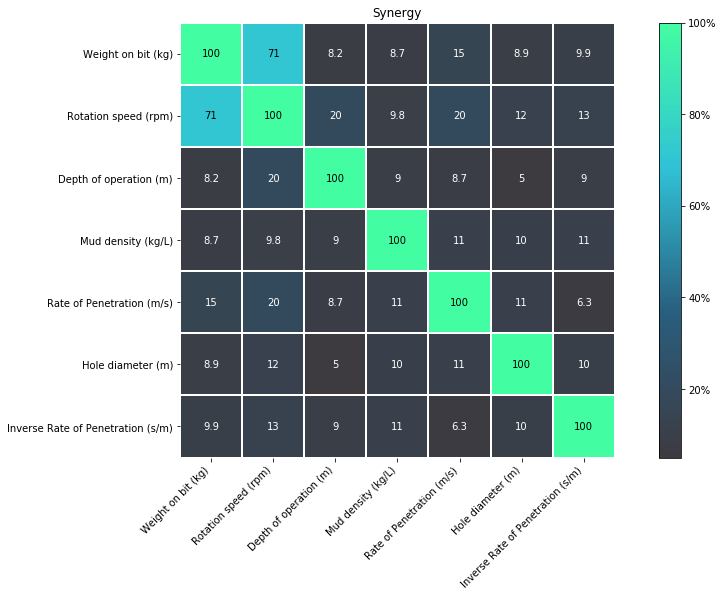

In [22]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

#### Feature importance

As the picture above shows a high redundancy level between the depth of operation and the hole diameter, both features compete in terms of feature importance. The dendrogram below shows that **Depth of operation** should be favored though to orthogonalise the feature set before simulation. 

The Rate of Penetration and Inverse Rate of Penetration are also obviously redundant. Inverse Rate of Penetration will be removed to orthogonalise the feature set before simulation.

nb: the redundancy coefficient (63%) between **Depth of operation** and **Hole diameter** is also visible on the dendrogram on x axis (feature distance: 1-redundancy)

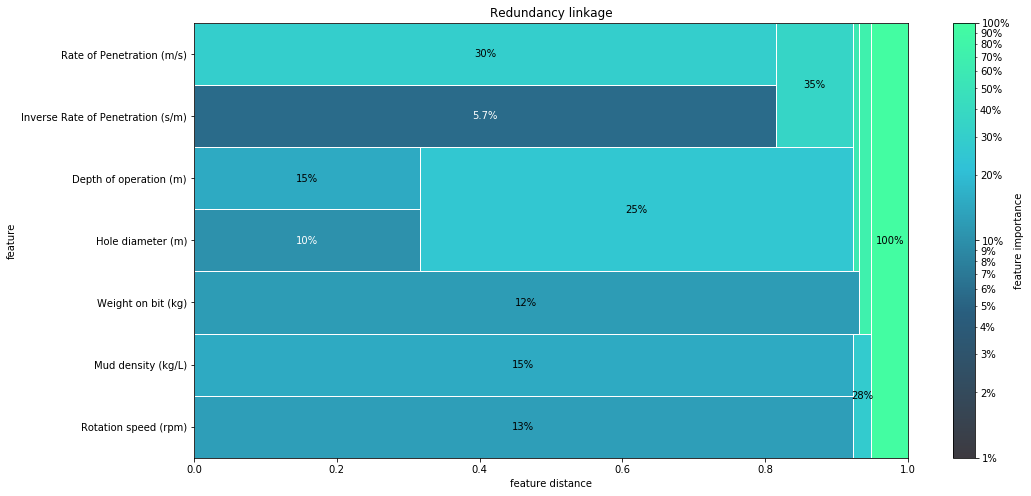

In [23]:
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

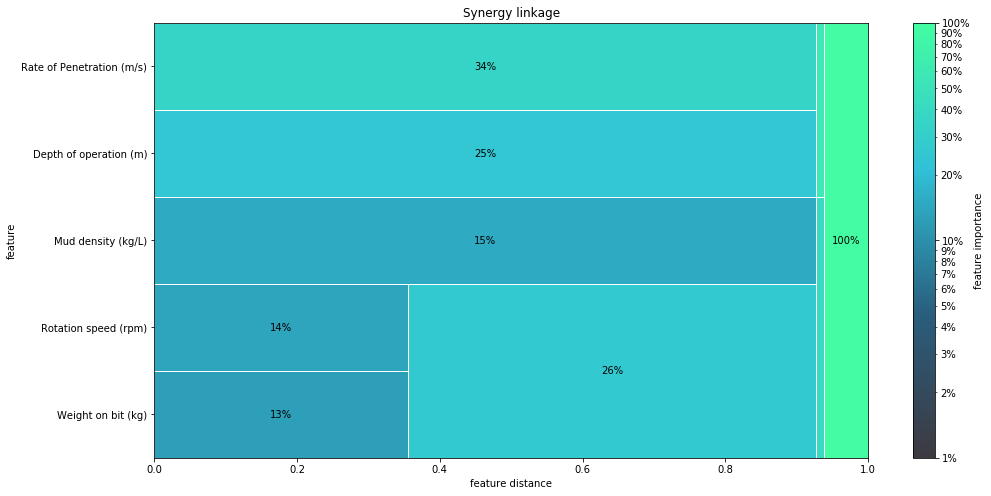

In [28]:
synergy = inspector.feature_association_linkage()
DendrogramDrawer().draw(title="Synergy linkage", data=synergy)

# Removing redundant features

In order to use the univariate simulator, we need to have an orthogonal set of features. This is needed such that artifially created examples stay plausible. Indeed not removing the Inverse Rate of Penetration feature from the set would lead to unrealistic artificial observations while using the univariate simulator.

The average predicted probability of the target variable resulting from this is computed for the partition.

In [24]:
# Remove redundant features
redundant_features = ["Hole diameter (m)", "Inverse Rate of Penetration (s/m)"]
sample_selected = sample_selected.drop(redundant_features)


ranker = LearnerRanker( 
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_selected)

inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


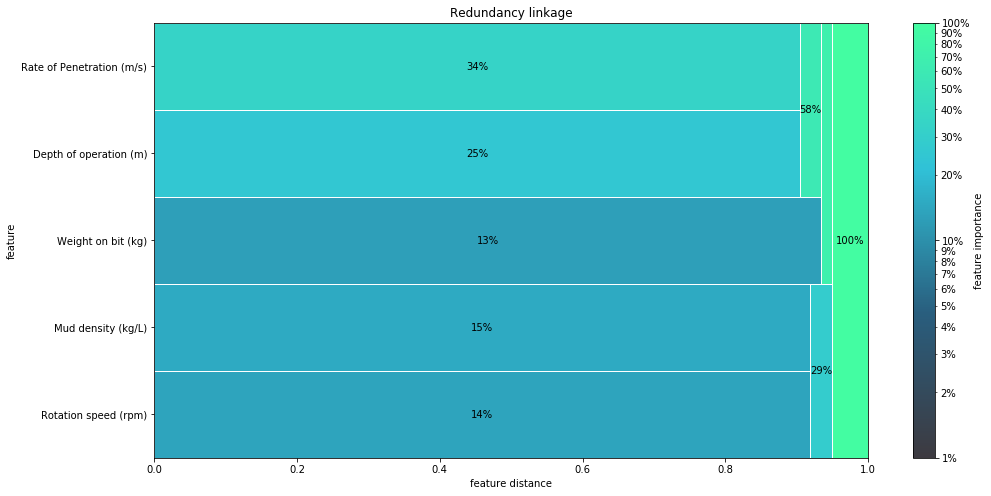

In [25]:
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

Now that our feature set is looking more linearly independant, we can start making simulations to gain knowledge into how Rate of Penetration will impact failure likelihood

# Simulation

The ROP is a parameter very much monitored while drilling a well as it is a tradeoff between safety and economy, it is safer to drill at a low pace but much costlier as it takes more time. It has also the highest feature importance in our model (see dendrogram above). Let's use a simulation to get a sense of how the failure likelihood behaves if we simulate changes in the ROP applied.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use the `facet.simulation.partition.ContinuousRangePartitioner` to split the range of observed values of the ROP into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best LearnerCrossfit acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds, and determines the average uplift of the target variable resulting from this.
- The `facet.simulation.viz.SimulationDrawer` displays the result; both in a matplotlib and a plain-text style

There is a 20% synergy between ROP and the rotation speed feature, hence there exist an interaction between both variables that is not expressed in our dataset. As such, some of the reproduced artificial examples will break this interaction impacting slightly the accuracy of the simulation. As the interaction is relatively low and rotation speed remains a variable with strong predictive power, we make the decision not keep it in the feature set.

In [26]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)
cont_partitioner = ContinuousRangePartitioner()

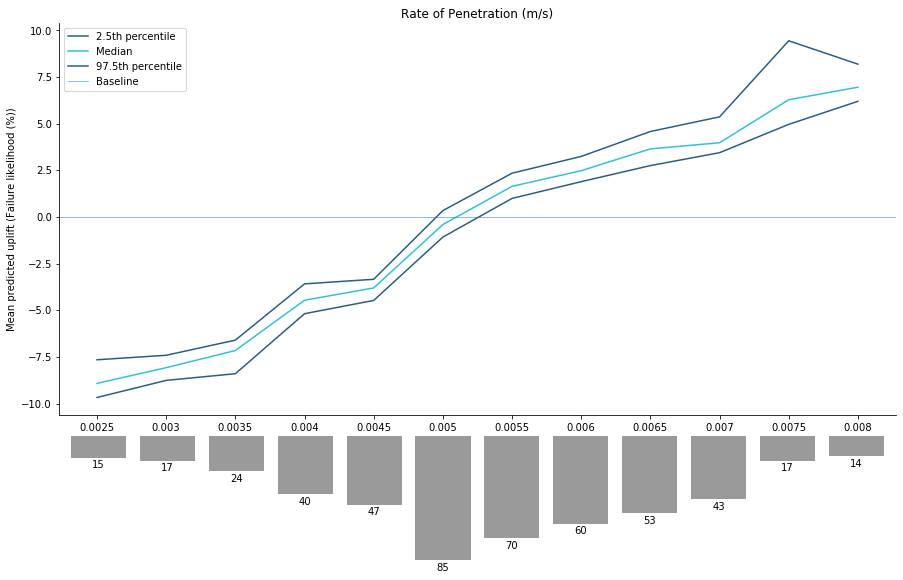

In [27]:
SIM_FEATURE = 'Rate of Penetration (m/s)'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner=cont_partitioner)

fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

The simulation can be used to get hindsights on failure likelihood changes depending on the RoP applied. As an example, the simulation suggests that reducing the ROP from 0.5 to 0.45 m/s would reduce failure likelihood by 4%

# Other below:
To be deleted

In [30]:
# From the synergy matrix, we can see that the **Weight on Bit** has the highest synergy with most other features. Therefore, we would want to see how the failure likelihood behaves if we simulate changes in the weight we apply to the drilling bit. 
#First of all, let's see if this is also confirmed by the SHAP feature importances. 
feat_importance = synergy_matrix.sum(axis=0).reset_index().rename({0: "Total Synergies"}, axis=1)
feat_importance["Total Synergies"] -= 1
feat_importance.sort_values(by="Total Synergies", ascending=False)

,feature,Total Synergies
0,Weight on bit (kg),1.190342
1,Rotation speed (rpm),1.151593
4,Rate of Penetration (m/s),0.843368
2,Depth of operation (m),0.603250
3,Mud density (kg/L),0.403587


We can see that the strong synergies with all other features of the **Weight on Bit** is also visible in the aboslute SHAP values. 

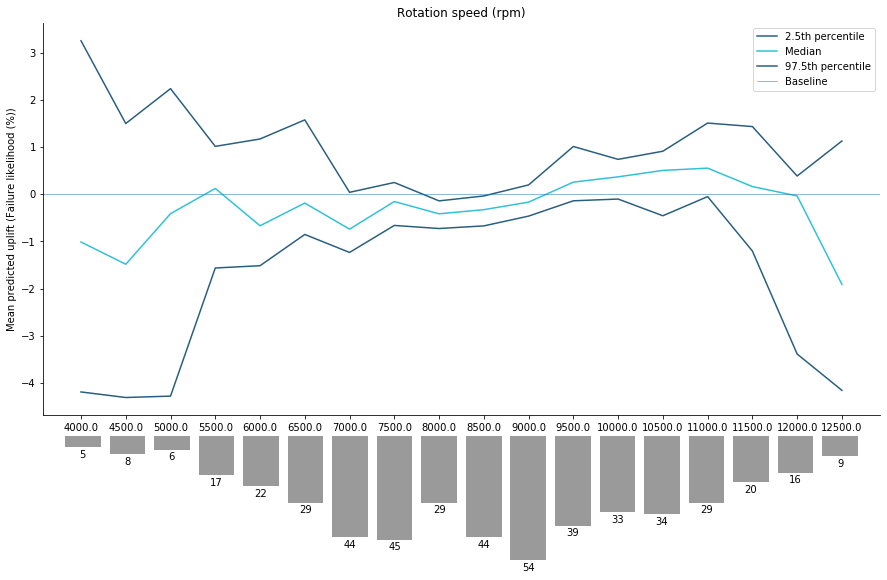

In [300]:
SIM_FEATURE = 'Rotation speed (rpm)'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = cont_partitioner)

fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

In [31]:
redundant_features = ["Bit depth [m]"]
sample_selected = sample_selected.drop(redundant_features)

#### Feature synergy
When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the weight on the bit and the drill rate in combination appear to have a high synergy. 

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionally large impact on the wear of the equipment.

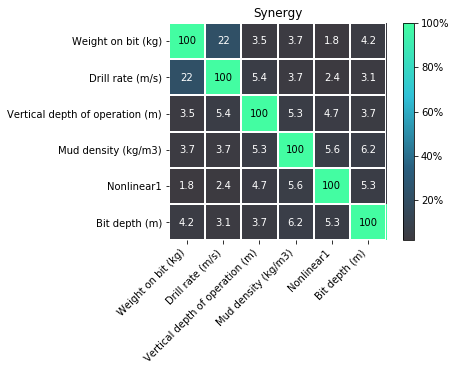

In [32]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [33]:
synergy_matrix

feature,Weight on bit (kg),Drill rate (m/s),Vertical depth of operation (m),Mud density (kg/m3),Nonlinear1,Bit depth (m)
feature,,,,,,
Weight on bit (kg),1.000000,0.223634,0.035250,0.036981,0.017894,0.042466
Drill rate (m/s),0.223634,1.000000,0.054254,0.036849,0.023992,0.031250
Vertical depth of operation (m),0.035250,0.054254,1.000000,0.052968,0.047340,0.037106
Mud density (kg/m3),0.036981,0.036849,0.052968,1.000000,0.056279,0.061785
Nonlinear1,0.017894,0.023992,0.047340,0.056279,1.000000,0.053226
Bit depth (m),0.042466,0.031250,0.037106,0.061785,0.053226,1.000000


# Simulation

From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we would want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature. 

First of all, let's see if this is also confirmed by the SHAP feature importances. 

In [26]:
feat_importance = synergy_matrix.sum(axis=0).reset_index().rename({0: "Total Synergies"}, axis=1)
feat_importance["Total Synergies"] -= 1

In [27]:
feat_importance.sort_values(by="Total Synergies", ascending=False)

,feature,Total Synergies
1,Drill rate (m/s),0.424472
0,Weight on bit (kg),0.390824
3,Mud density (kg/m3),0.322319
2,Vertical depth of operation (m),0.306369
5,Bit depth (m),0.295878
4,Nonlinear1,0.273354


We can see that the strong synergies with all other features of the Compressor outlet air temperature is also visible in the aboslute SHAP values. 

In [28]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

In [38]:
cont_partitioner = ContinuousRangePartitioner()

In [39]:
SIM_FEATURE = 'Weight on bit (kg)'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = cont_partitioner)

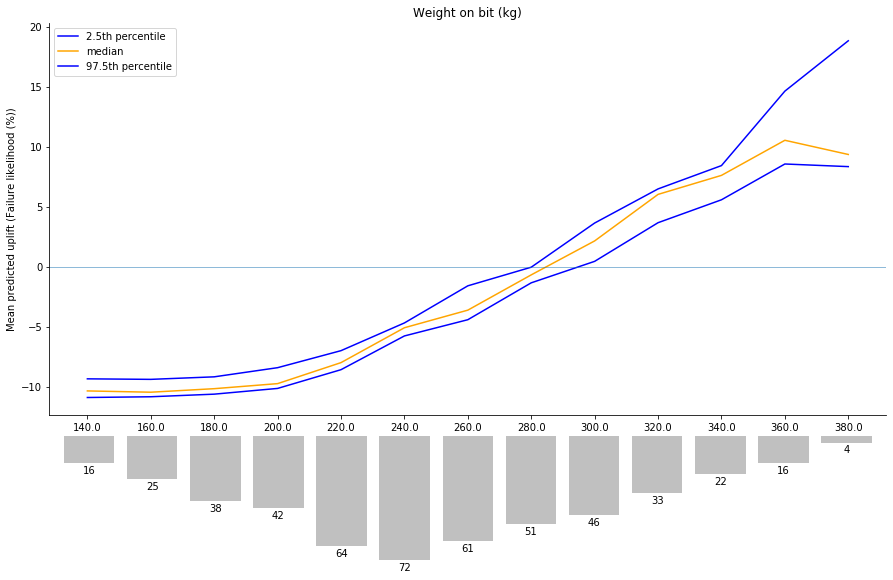

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)